# Delta Convective Map/Delta Time

In [1]:
import xarray as xr
import xoak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob

## Data 

In [3]:
#find all CSVs with convective modes
files = glob.glob('/home/jcorner1/Unidata/csv/storm_modes_*.csv')

#merge csv files
df = pd.concat(map(pd.read_csv, files), ignore_index=True)
df['Time'] =  pd.to_datetime(df['Time'])
df

,Unnamed: 0,x,y,Filename,Time,Mode
0,0,261,548,10021991_T22_0id.npy,1991-10-02 22:00:00,other
1,1,261,549,10021991_T22_1id.npy,1991-10-02 22:00:00,other
2,2,572,400,10101991_T01_2id.npy,1991-10-10 01:00:00,tightly_clustered_cells
3,3,573,400,10101991_T01_3id.npy,1991-10-10 01:00:00,tightly_clustered_cells
4,4,574,400,10101991_T01_4id.npy,1991-10-10 01:00:00,tightly_clustered_cells
...,...,...,...,...,...,...
151022,10331,610,600,09142005_T02_10831id.npy,2005-09-14 02:00:00,loosely_clustered_cells
151023,10332,611,600,09142005_T02_10832id.npy,2005-09-14 02:00:00,loosely_clustered_cells
151024,10333,612,600,09142005_T02_10833id.npy,2005-09-14 02:00:00,loosely_clustered_cells
151025,10334,613,600,09142005_T02_10834id.npy,2005-09-14 02:00:00,loosely_clustered_cells


In [ ]:
##### Devise a method of not double counting the same storm #########



In [5]:

def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds_mask: a masked xarray dataset
    
    '''
    geog = xr.open_dataset("/home/scratch/ahaberlie/simgeog/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    #mask out area 
    ds_mask = mask_data(ds)
    
    
    return ds_mask

def mask_data(in_data):
    
    '''
    A defintion masking data in the US, east of the Rockies. 
    
    Parameters
    ----------
    in_data: xarray dataset
    
    Returns
    -------
    out_data: a masked xarray dataset
    
    '''
    
    usa = gpd.read_file("/home/jcorner1/Unidata/shapefiles/smoothing_econus.shp")

    state_mask = regionmask.mask_geopandas(usa, in_data.lon, in_data.lat)
    ma = state_mask.values
    ma[~np.isnan(ma)] = 1

    out_data = in_data * ma
    
    return out_data


ds = xr.open_dataset('/home/scratch/ahaberlie/AFWA_2-5KM_UPDRAFT_HELICITY/HIST/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()
ds_copy


###### USED as TEMP data (will be deleted) #######################

modes = ['isolated_cell', 'multiple_isolated_cells', 'loosely_clustered_cells', 'tightly_clustered_cells', 'qlcs', 'other']


for mode in modes:
    
    print(mode)
    
    locals()[f'{mode}_blanks'] = np.zeros((899,1399))
    cur_mode = df[(df['Mode'] == mode)]
    
    for rid, row in cur_mode.iterrows():
        locals()[f'{mode}_blanks'][row['y'], row['x']] = locals()[f'{mode}_blanks'][row['y'], row['x']] + 1
    
    locals()[f'{mode}_blanks'][locals()[f'{mode}_blanks'] == 0.0] = np.nan
    
    locals()[f'ds_{mode}'] = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), locals()[f'{mode}_blanks']))

    locals()[f'ds_cov_{mode}'] =  Data_Conv(locals()[f'ds_{mode}'])
    print(np.nanmax(locals()[f'ds_cov_{mode}'].UP_HELI_MAX.values))

isolated_cell
73.0
multiple_isolated_cells
166.0
loosely_clustered_cells
101.0
tightly_clustered_cells
490.0
qlcs
326.0
other
208.0


## Calculate Deltas

In [8]:
#open files to calculate the change between the values
hist = ds_cov_tightly_clustered_cells
futr = ds_cov_qlcs

In [10]:
delta_mode = (futr.UP_HELI_MAX.values/15) - (hist.UP_HELI_MAX.values/15)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

## Graphs

Text(0.03, 0.05, 'FUTR 8.5 - QLCS')

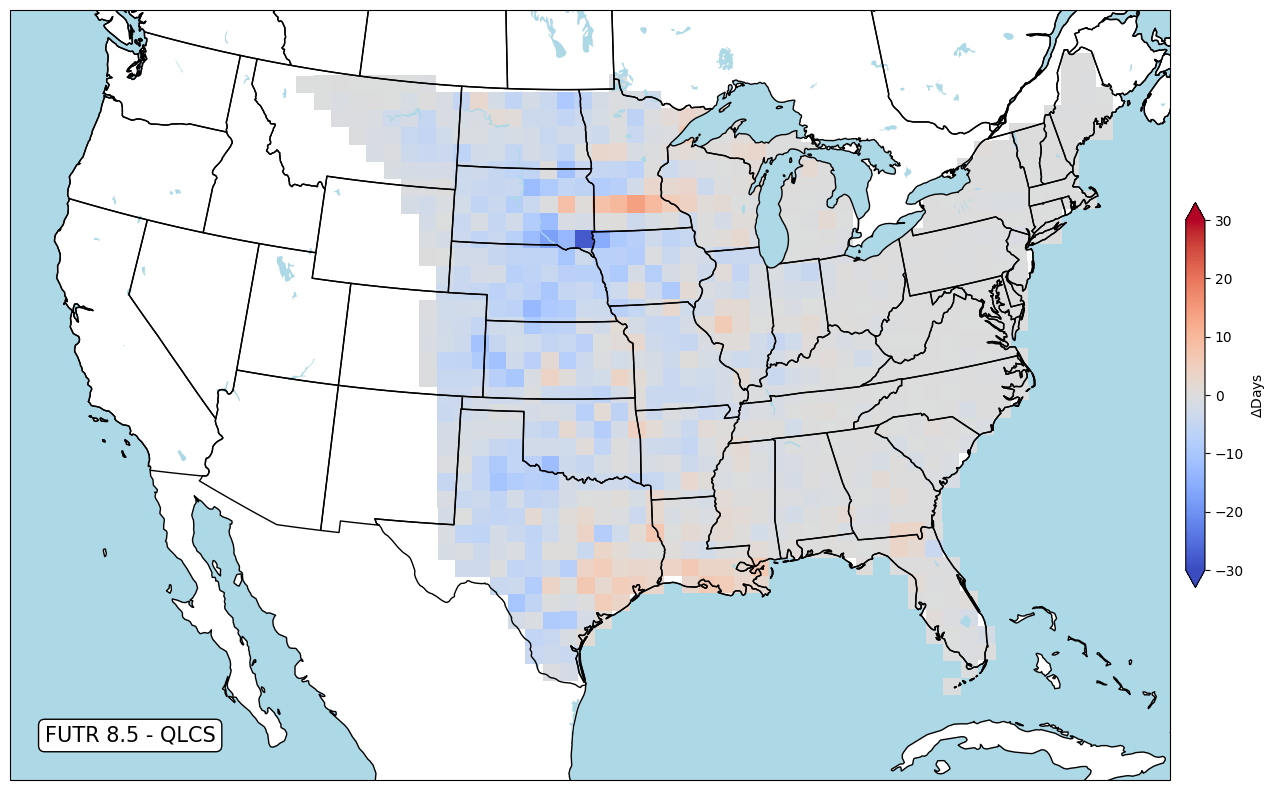

In [31]:
from matplotlib import colors

#Plot the data
fig = plt.figure()
plt.rcParams['figure.figsize'] = 20,10
divnorm=colors.TwoSlopeNorm(vmin=-30., vcenter=0., vmax=30)

ax = plt.subplot(1, 1, 1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

c = ax.pcolormesh(futr.lon.values, futr.lat.values, delta_mode, transform=cartopy.crs.PlateCarree(), cmap='coolwarm', norm=divnorm)

ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')

ax.set_extent([-120, -74, 20, 50])


cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(-30, 31, 10)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='$\Delta$Days', size=10)


ax.annotate(f'FUTR 8.5 - QLCS', (0.03,0.05), xycoords='axes fraction',fontsize=15, 
                        bbox=dict(boxstyle='round', facecolor='w', alpha=1), color='k',zorder=25)